## Load Dataset

In [2]:
import psycopg2
import pandas as pd
import json

# Connessione al database
conn = psycopg2.connect(
    dbname="scientilla",
    user="postgres",
    password="pwd",
    host="localhost",
    port=5444
)

# Query
query = """
SELECT ri.data
FROM research_item AS ri
JOIN research_item_type AS rit
    ON ri.research_item_type_id = rit.id
WHERE rit.type = 'publication'
ORDER BY ri.id
LIMIT 100;
"""

# Leggi il risultato come DataFrame
df = pd.read_sql(query, conn)
print(df)

data_array = df["data"].tolist()[:100]


                                                 data
0   {'doi': '10.1016/j.jconrel.2011.10.021', 'year...
1   {'doi': '10.1002/adfm.202400982', 'year': '202...
2   {'doi': '10.1016/j.jnucmat.2024.155121', 'year...
3   {'doi': '10.1103/PhysRevB.94.165155', 'year': ...
4   {'doi': '10.1039/c2jm15117k', 'year': '2012', ...
..                                                ...
95  {'doi': '10.3390/s150304913', 'year': '2015', ...
96  {'doi': '10.1002/app.55527', 'year': '2024', '...
97  {'doi': '10.1515/nanoph-2019-0199', 'year': '2...
98  {'doi': '10.1093/nar/gkae172', 'year': '2024',...
99  {'doi': '10.1021/acsenergylett.8b00193', 'year...

[100 rows x 1 columns]


/tmp/ipykernel_9383/2633991503.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Preprocessing

In [3]:
def clean_item(item):
    year = item.get("year") or ""
    title = item.get("title") or ""
    abstract = item.get("abstract") or ""
    title = item.get("title") or ""
    abstract = item.get("abstract") or ""
    if abstract:
      text = f"{title}. {abstract}. {year}"
    else:
      text = f"{title}. {year}"
    return text.strip()

cleaned_strings = [clean_item(d) for d in data_array]

for s in cleaned_strings:
    print(s)

Rapid tumoritropic accumulation of systemically injected plateloid particles and their biodistribution. Nanoparticles for cancer therapy and imaging are designed to accumulate in the diseased tissue by exploiting the Enhanced Permeability and Retention (EPR) effect. This limits their size to about 100 nm. Here, using intravital microscopy and elemental analysis, we compare the in vivo localization of particles with different geometries and demonstrate that plateloid particles preferentially accumulate within the tumor vasculature at unprecedented levels, independent of the EPR effect. In melanoma-bearing mice, 1000 × 400 nm plateloid particles adhered to the tumor vasculature at about 5% and 10% of the injected dose per gram organ (ID/g) for untargeted and RGD-targeted particles respectively, and exhibited the highest tumor-to-liver accumulation ratios (0.22 and 0.35). Smaller and larger plateloid particles, as well as cylindroid particles, were more extensively sequestered by the live

## Dataset Embedding Generation

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

model = SentenceTransformer("sentence-transformers/allenai-specter")

doc_texts = [json.dumps(d, ensure_ascii=False) for d in data_array]
doc_ids = [d.get("doi") or f"idx_{i}" for i, d in enumerate(data_array)]

doc_embeddings = model.encode(
    doc_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)

np.save("embeddings/doc_embeddings_specter2.npy", doc_embeddings)

with open("doc_ids.json", "w", encoding="utf-8") as f:
    json.dump(doc_ids, f, ensure_ascii=False, indent=2)

print("Saved doc_embeddings.npy and doc_ids.json")


/home/msenes-iit.local/projects/scientilla_ai/myEnv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved doc_embeddings.npy and doc_ids.json


### Clustering

/tmp/ipykernel_9383/3345095364.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


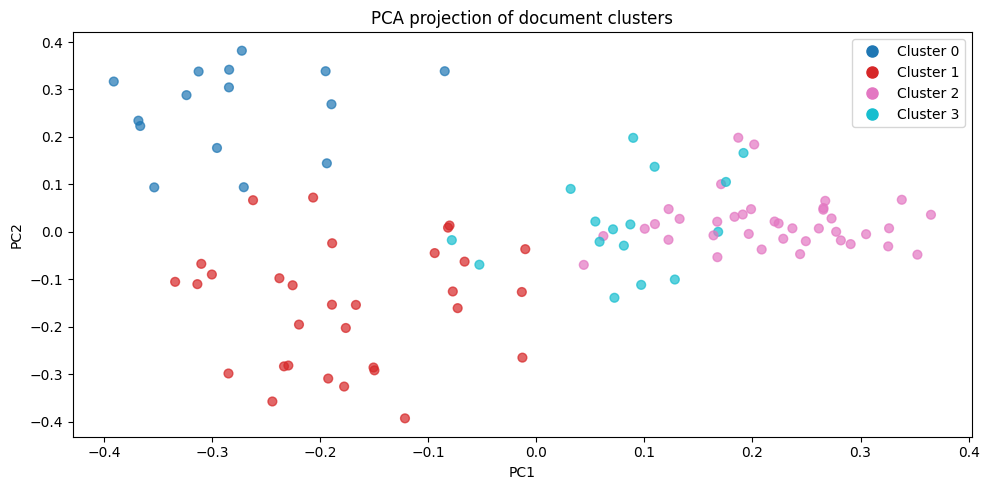


=== Cluster 0 ===
- Dynamic distributed intrusion detection for secure Multi-Robot systems
- Inconsistency of perceived 3D shape
- A Bioinspired Multifunctional Soft Gripper with Embedded Sensing Ability: A potential way for sustainable agricultural harvesting
- Robots trends and megatrends: artificial intelligence and the society
- A robot-based assessment of trunk control in Spinal Cord Injured athletes
- Modelling and control design of a novel robotic membrane
- Assessment of the Monitor System Interface: A Setup System Tool for Industrial Exoskeletons
- Autonomous Battery Exchange of UAVs with a Mobile Ground Base
- Computing the COM from the COP in postural sway movements
- Neuromotor control in handwriting and drawing: introduction and overview.
- ALICIA an architecture for intelligent affective agents
- Accurate trajectory transformations for redundant and nonredundant robots
- Guest Editorial Special Issue on Emerging Topics on Development and Learning
- Arm muscle synergies e

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

titles = [d.get("title") or "" for d in data_array]  # extract titles

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(doc_embeddings)

cmap = cm.get_cmap("tab10", n_clusters)
colors = [cmap(l) for l in labels]

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()

# Print documents grouped by cluster
for c in range(n_clusters):
    print(f"\n=== Cluster {c} ===")
    indices = np.where(labels == c)[0]
    for idx in indices:
        print(f"- {titles[idx]}")


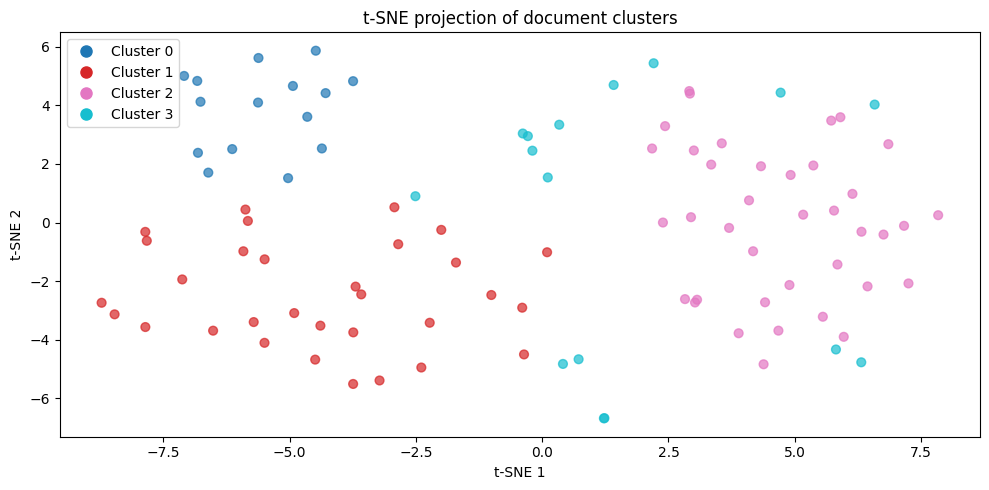

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
emb_2d_tsne = tsne.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d_tsne[:, 0],
    emb_2d_tsne[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()


## Load Embeddings

In [7]:
import numpy as np
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer("sentence-transformers/allenai-specter")

doc_embeddings = np.load("embeddings/doc_embeddings_specter2.npy")

with open("doc_ids.json", "r", encoding="utf-8") as f:
    doc_ids = json.load(f)


## Testing

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, top_k=5):
    q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    sims = cosine_similarity(q_emb, doc_embeddings)[0]

    ranked = np.argsort(-sims)
    k = min(top_k, len(ranked))

    print(f"\n=== Query: {query!r} ===")
    for i in range(k):
        idx = ranked[i]
        score = sims[idx]
        doc_id = doc_ids[idx]
        text = cleaned_strings[idx]

        print(f"\n[{i+1}] id={doc_id}  score={score:.3f}")
        print(f"     text: {text[:200]}{'...' if len(text) > 200 else ''}")


In [9]:
test_queries = ['renewable energies','heart', 'cardiology', 'nature','biology']

for q in test_queries:
    search(q, top_k=5)


=== Query: 'renewable energies' ===

[1] id=10.1016/j.nimb.2009.03.058  score=0.703
     text: IBIC analysis of CdTe/CdS solar cells. This paper reports on the investigation of the electronic properties of a thin film CdS/CdTe solar cell with the Ion Beam Induced Charge (IBIC) technique. The de...

[2] id=10.1039/c2jm15117k  score=0.697
     text: Aqueous processing of cellulose based paper-anodes for flexible Li-ion batteries. Cellulose fibers were used as novel bio-sourced binder to manufacture flexible cellulose/graphite paper-anodes for Li-...

[3] id=10.1088/2634-4386/ad3a96  score=0.676
     text: An organic artificial soma for spatio-temporal pattern recognition via dendritic integration. A novel organic neuromorphic device performing pattern classification is presented and demonstrated. It fe...

[4] id=10.1002/slct.201601037  score=0.675
     text: One-Pot Microwave-Assisted Synthesis of Reduced Graphene Oxide/Iron Oxide Nanocomposite Catalyst for the Oxygen Reduction Reactio

## Adapters

In [10]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
from adapters import AutoAdapterModel

tokenizer = AutoTokenizer.from_pretrained("allenai/specter2_base")
model = AutoAdapterModel.from_pretrained("allenai/specter2_base")


model.load_adapter(
    "allenai/specter2",
    source="hf",
    load_as="specter2",
    set_active=True
)

papers = data_array 
texts = [
    d["title"] + tokenizer.sep_token + (d.get("abstract") or "")
    for d in papers
]

def encode_specter2(texts, batch=16):
    model.eval()
    all_vecs = []

    with torch.no_grad():
        for i in range(0, len(texts), batch):
            chunk = texts[i:i+batch]

            inp = tokenizer(
                chunk,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt",
                return_token_type_ids=False
            )

            out = model(**inp)
            emb = out.last_hidden_state[:, 0, :]
            all_vecs.append(emb.cpu().numpy())

    return np.vstack(all_vecs)

embeddings = encode_specter2(texts)
print("Embeddings shape:", embeddings.shape)

np.save("specter2_embeddings.npy", embeddings)

with open("specter2_papers.json", "w", encoding="utf-8") as f:
    json.dump(papers, f, ensure_ascii=False, indent=2)


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 19996.68it/s]
There are adapters available but none are activated for the forward pass.


Embeddings shape: (100, 768)


/tmp/ipykernel_9383/1003279776.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


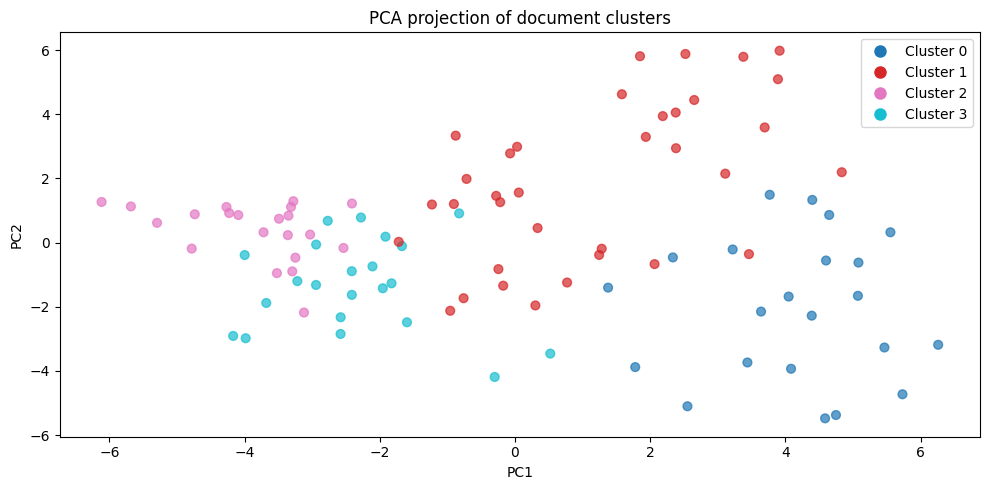


=== Cluster 0 ===
- A new perspective on positive symptoms: expression of damage or self-defence mechanism of the brain?
- Dynamic distributed intrusion detection for secure Multi-Robot systems
- Inconsistency of perceived 3D shape
- An organic artificial soma for spatio-temporal pattern recognition via dendritic integration
- Image Analysis and Processing – ICIAP 2015: 18th International Conference Genoa, Italy, September 7–11, 2015 Proceedings, Part II
- Dominance of Metric Correlations in Two-Dimensional Neuronal Cultures Described through a Random Field Ising Model
- Robots trends and megatrends: artificial intelligence and the society
- A robot-based assessment of trunk control in Spinal Cord Injured athletes
- See Elegans: Simple-to-use, accurate, and automatic 3D detection of neural activity from densely packed neurons
- Modelling and control design of a novel robotic membrane
- Assessment of the Monitor System Interface: A Setup System Tool for Industrial Exoskeletons
- Autono

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

titles = [d.get("title") or "" for d in data_array]

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

cmap = cm.get_cmap("tab10", n_clusters)
colors = [cmap(l) for l in labels]

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()

for c in range(n_clusters):
    print(f"\n=== Cluster {c} ===")
    indices = np.where(labels == c)[0]
    for idx in indices:
        print(f"- {titles[idx]}")


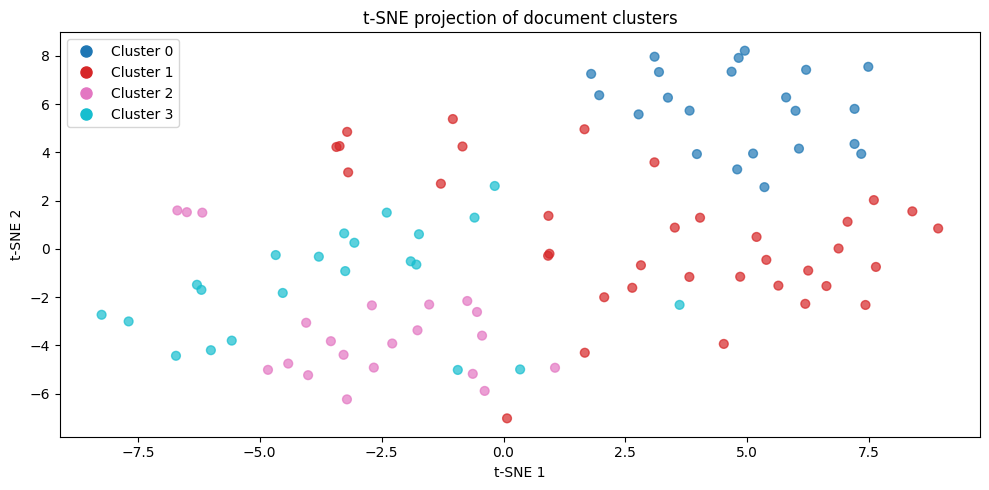

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
emb_2d_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d_tsne[:, 0],
    emb_2d_tsne[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import json

embeddings = np.load("specter2_embeddings.npy")

with open("specter2_papers.json", "r", encoding="utf-8") as f:
    papers = json.load(f)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def encode_query(query):
    inp = tokenizer(
        [query],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt",
        return_token_type_ids=False
    )
    with torch.no_grad():
        out = model(**inp)
    return out.last_hidden_state[:, 0, :].cpu().numpy()


In [15]:
def search(query, top_k=5):
    q_emb = encode_query(query)
    sims = cosine_similarity(q_emb, embeddings)[0]
    idx = np.argsort(-sims)[:top_k]

    print(f"\n=== Query: {query} ===")
    for i, j in enumerate(idx):
        print(f"\n[{i+1}] score={sims[j]:.4f}")
        print("title:", papers[j]["title"])
        print("abstract:", (papers[j].get("abstract") or "")[:300], "...")

search("Renewable energies", top_k=7)



=== Query: Renewable energies ===

[1] score=0.8987
title: Fully Screen-Printed, Flexible, and Scalable Organic Monolithic Thermoelectric Generators
abstract: Energy-harvesting technologies offer a sustainable, maintenance-free alternative to conventional energy-storage solutions in distributed low-power applications. Flexible thermoelectric generators (TEGs) can generate electric power from a temperature gradient, even on complex surfaces. Organic materi ...

[2] score=0.8904
title: Robots trends and megatrends: artificial intelligence and the society
abstract: Purpose: The purpose of this study is to analyze the robot trends of the next generation. Design/methodology/approach: This paper is divided into two sections: the key modern technology on which Europe's robotics industry has built its foundation is described. Then, the next key megatrends were anal ...

[3] score=0.8847
title: A Rolled Organic Thermoelectric Generator with High Thermocouple Density
abstract: The surge in the 